# Rossmann Sales Forecasting — Phase 1 and Phase 2 (Lesson-Style Notebook)

What we are doing in this notebook is building a complete and understandable foundation for forecasting store sales.

We first study the data carefully (Phase 1: EDA), then transform raw columns into model-ready features (Phase 2: Feature Engineering).

The guiding principles are:
- no time leakage,
- clear feature semantics,
- reproducible outputs for downstream modeling,
- explanations that make each design choice understandable.

In [1]:
import warnings
import gc
warnings.filterwarnings('ignore')

# Core data stack
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scaling for numeric features in phase 2
from sklearn.preprocessing import RobustScaler

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

## 0) Load the Data

What we are doing here is reading the competition files and preparing data types correctly from the beginning.

A key detail is converting `Date` to datetime immediately, because all time-based features depend on this being correct.

In [2]:
# File paths
train_path = '../data/competition/train.csv'
store_path = '../data/competition/store.csv'

# Read raw competition files
train_df = pd.read_csv(train_path, low_memory=False)
store_df = pd.read_csv(store_path, low_memory=False)

# Keep Date as datetime from the start (needed for all time features)
train_df['Date'] = pd.to_datetime(train_df['Date'])

print('Train shape:', train_df.shape)
print('Store shape:', store_df.shape)
train_df.head()

Train shape: (1001599, 10)
Store shape: (1115, 10)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id
0,1,5,2015-07-17,4852,519,1,1,0,0,303445
1,2,5,2015-07-17,4518,495,1,1,0,1,959585
2,3,5,2015-07-17,6679,673,1,1,0,1,739744
3,4,5,2015-07-17,10514,1343,1,1,0,1,864001
4,5,5,2015-07-17,4355,513,1,1,0,1,981931


### Data Quality Check: Missing Values in Raw Inputs

What we are doing in the next code cell is computing missing-value counts separately for `train` and `store`.

This tells us exactly which columns need explicit treatment in feature engineering.

In [3]:
print('Missing values in train (>0):')
display(train_df.isna().sum()[train_df.isna().sum() > 0].sort_values(ascending=False).to_frame('missing_count'))

print('Missing values in store (>0):')
display(store_df.isna().sum()[store_df.isna().sum() > 0].sort_values(ascending=False).to_frame('missing_count'))

Missing values in train (>0):


,missing_count


Missing values in store (>0):


,missing_count
Promo2SinceWeek,544
Promo2SinceYear,544
PromoInterval,544
CompetitionOpenSinceMonth,354
CompetitionOpenSinceYear,354
CompetitionDistance,3


## Phase 1 — Exploratory Data Analysis (EDA)

What we are doing in this phase is understanding how sales behave before creating features.

This helps us answer:
- Which variables are likely predictive?
- Which patterns are seasonal or weekly?
- Which artifacts are noise and which are meaningful?

### 1) Sales Trends for Representative Stores

What we are doing is selecting stores from different sales quantiles and plotting both raw daily sales and a 30-day moving average.

This gives us two views at once:
- short-term volatility,
- medium-term trend direction.

In [4]:
# Select stores from different sales quantiles so trends are not biased to only high-volume stores
store_sales = train_df.groupby('Store')['Sales'].agg(['mean', 'count']).sort_values('mean', ascending=False)

selected_stores = [
    store_sales.index[0],
    store_sales.index[len(store_sales)//4],
    store_sales.index[len(store_sales)//2],
    store_sales.index[(3*len(store_sales))//4],
    store_sales.index[-1],
]

# Keep one subset for all comparison plots
selected_data = train_df[train_df['Store'].isin(selected_stores)].copy().sort_values('Date')

print('Selected stores:', selected_stores)
selected_data[['Store', 'Date', 'Sales']].head()

Selected stores: [np.int64(262), np.int64(655), np.int64(692), np.int64(317), np.int64(307)]


,Store,Date,Sales
1001176,692,2013-01-01,0
1000746,262,2013-01-01,17267
1001139,655,2013-01-01,0
1000801,317,2013-01-01,0
1000791,307,2013-01-01,0


### Plotting Sales Time Series with Moving Average

What we are doing in the next code cell is plotting each selected store as:
- raw daily sales,
- 30-day moving average.

This combination helps separate noise from trend.

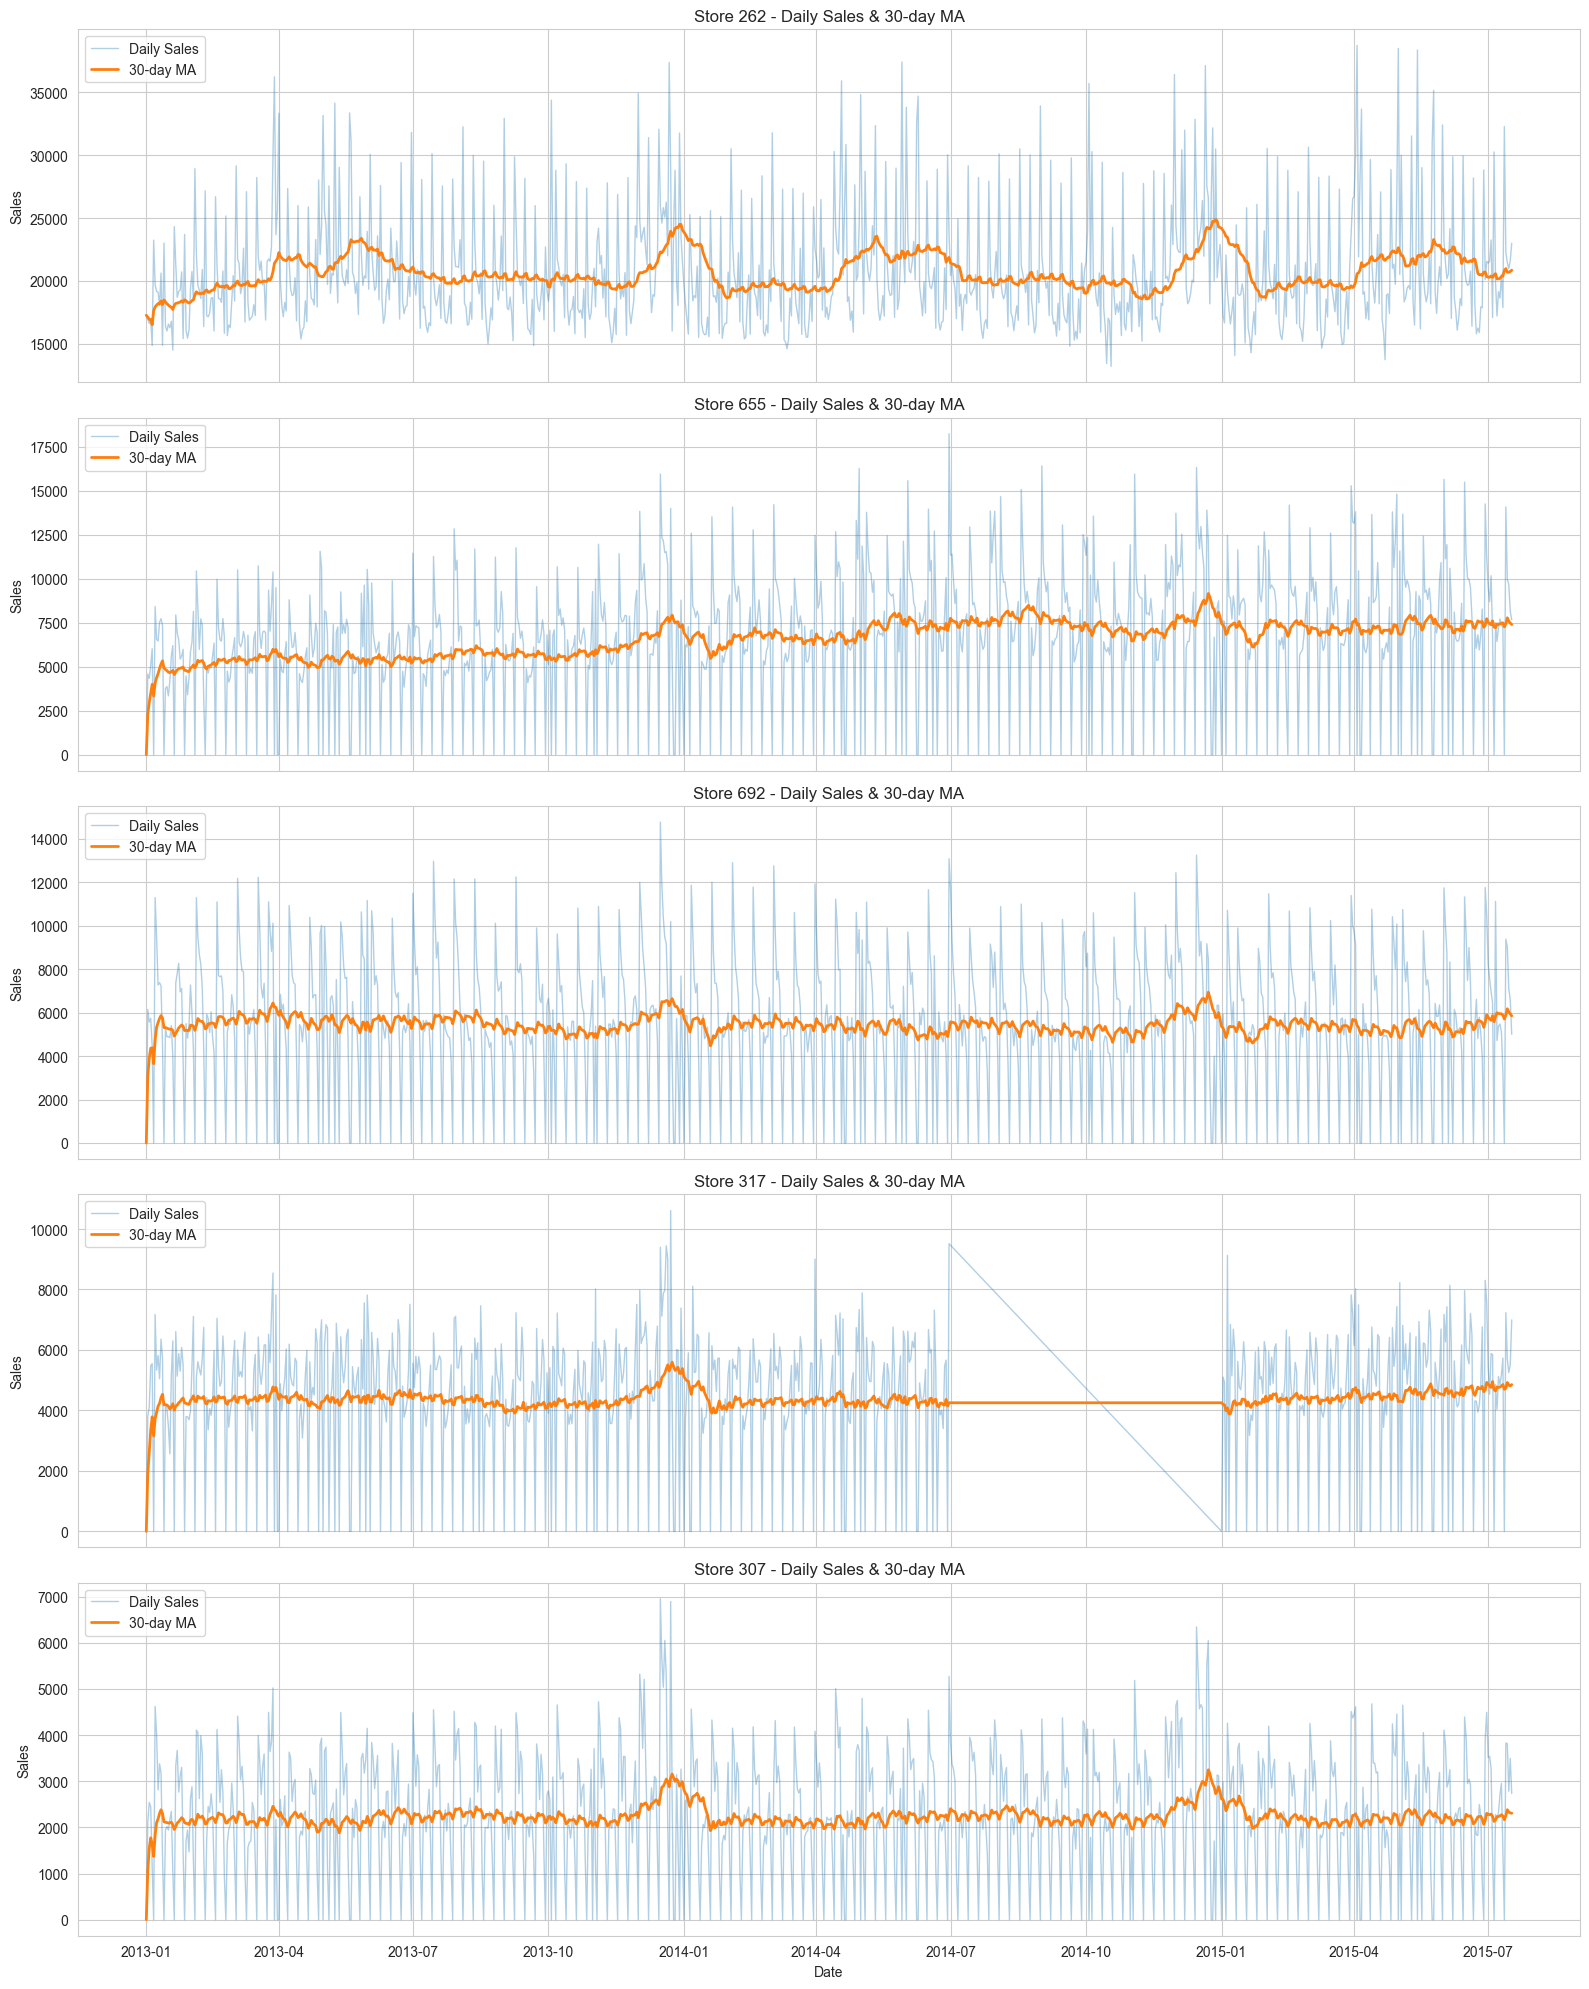

In [5]:
fig, axes = plt.subplots(len(selected_stores), 1, figsize=(16, 4 * len(selected_stores)), sharex=True)

for i, store_id in enumerate(selected_stores):
    # Per-store timeline
    tmp = selected_data[selected_data['Store'] == store_id].sort_values('Date').copy()
    # 30-day moving average to separate trend from daily noise
    tmp['Sales_MA30'] = tmp['Sales'].rolling(30, min_periods=1).mean()

    ax = axes[i] if len(selected_stores) > 1 else axes
    ax.plot(tmp['Date'], tmp['Sales'], alpha=0.35, linewidth=1.0, label='Daily Sales')
    ax.plot(tmp['Date'], tmp['Sales_MA30'], linewidth=2.0, label='30-day MA')
    ax.set_title(f'Store {store_id} - Daily Sales & 30-day MA')
    ax.set_ylabel('Sales')
    ax.legend(loc='upper left')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

### 2) Feature Impact Visualization

What we are doing is comparing sales distributions across important categorical conditions such as promotion and holidays.

The goal is not just to compare means, but to see distribution shape, spread, and outliers.

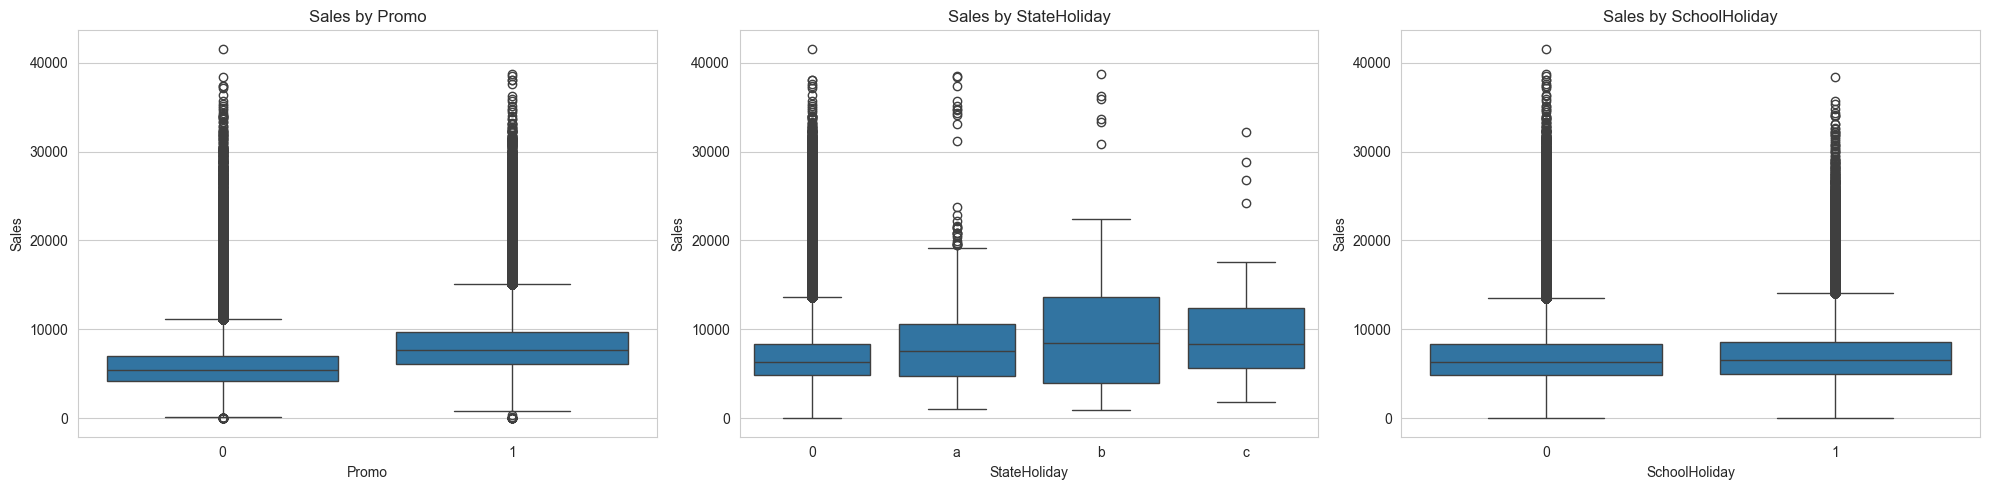

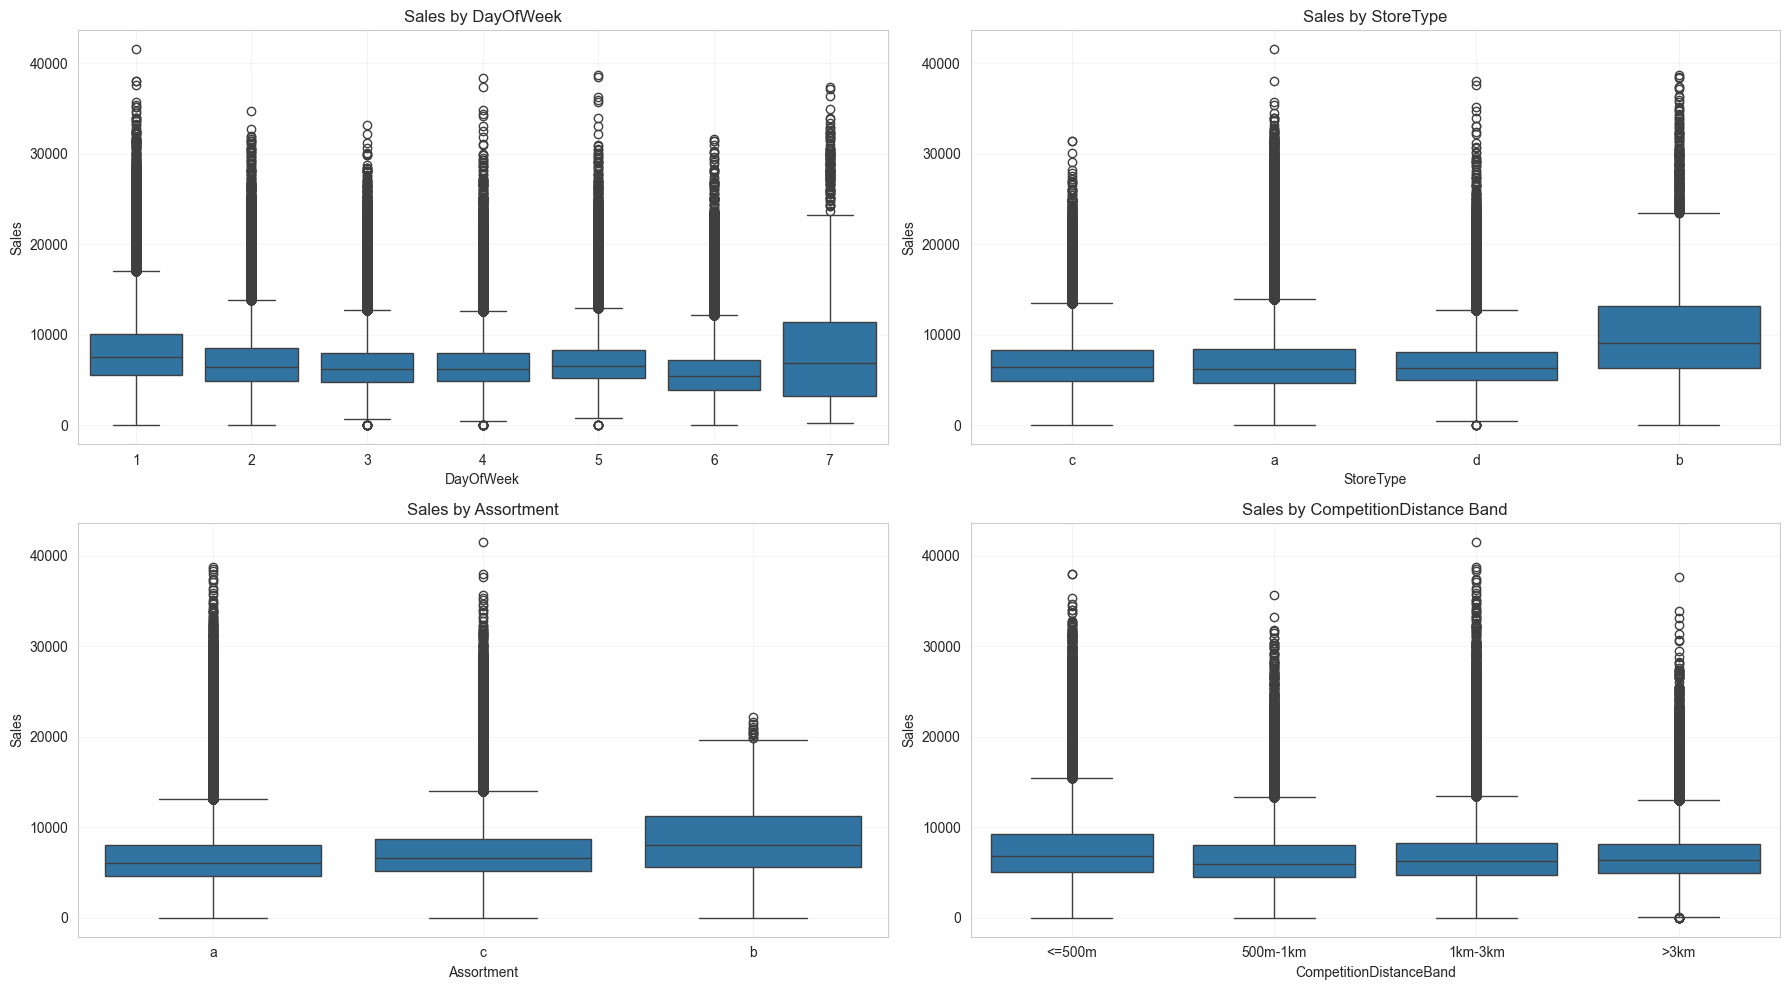

Promo mean/median sales:


,mean,median,count
Promo,,,
1,8224.401849,7644.0,371331
0,5930.334374,5458.0,459641


StateHoliday mean/median sales:


,mean,median,count
StateHoliday,,,
b,9887.889655,8423.0,145
c,9743.746479,8397.0,71
a,8487.471182,7556.0,694
0,6953.437611,6367.0,830062


SchoolHoliday mean/median sales:


,mean,median,count
SchoolHoliday,,,
1,7190.114678,6547.0,155514
0,6901.445672,6330.0,675458


DayOfWeek mean/median sales:


,mean,median,count
DayOfWeek,,,
1,8217.863944,7539.0,135334
7,8208.316804,6842.0,3529
2,7090.276749,6503.0,141735
5,7065.586186,6575.0,136414
4,6764.124115,6242.0,132418
3,6730.745924,6211.0,139710
6,5879.118161,5429.0,141832


StoreType mean/median sales:


,mean,median,count
StoreType,,,
b,10226.078695,9127.0,15325
c,6932.493462,6407.0,111202
a,6927.086826,6286.0,449853
d,6818.782998,6391.0,254592


Assortment mean/median sales:


,mean,median,count
Assortment,,,
b,8626.347762,8052.0,8086
c,7297.556539,6672.0,385085
a,6623.712547,6083.0,437801


CompetitionDistanceBand mean/median sales:


,mean,median,count
CompetitionDistanceBand,,,
<=500m,7614.106432,6792.0,165458
1km-3km,6885.605554,6260.0,218519
>3km,6768.692866,6347.0,363324
500m-1km,6677.210743,6000.0,81521


In [6]:
# Use only open days for fair impact comparison
viz_df = train_df[train_df['Open'] == 1].copy()
viz_df['StateHoliday'] = viz_df['StateHoliday'].astype(str)

# Add store-level features for richer impact analysis
viz_merged = viz_df.merge(
    store_df[['Store', 'StoreType', 'Assortment', 'CompetitionDistance']],
    on='Store',
    how='left'
 )

# Bin competition distance for interpretable group comparison
viz_merged['CompetitionDistanceBand'] = pd.cut(
    viz_merged['CompetitionDistance'],
    bins=[-np.inf, 500, 1000, 3000, np.inf],
    labels=['<=500m', '500m-1km', '1km-3km', '>3km']
 )

# -------- Core features from train.csv --------
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.boxplot(data=viz_df, x='Promo', y='Sales', ax=axes[0])
axes[0].set_title('Sales by Promo')

sns.boxplot(data=viz_df, x='StateHoliday', y='Sales', ax=axes[1])
axes[1].set_title('Sales by StateHoliday')

sns.boxplot(data=viz_df, x='SchoolHoliday', y='Sales', ax=axes[2])
axes[2].set_title('Sales by SchoolHoliday')

plt.tight_layout()
plt.show()

# -------- Additional useful features --------
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

sns.boxplot(data=viz_df, x='DayOfWeek', y='Sales', ax=axes[0, 0])
axes[0, 0].set_title('Sales by DayOfWeek')

sns.boxplot(data=viz_merged, x='StoreType', y='Sales', ax=axes[0, 1])
axes[0, 1].set_title('Sales by StoreType')

sns.boxplot(data=viz_merged, x='Assortment', y='Sales', ax=axes[1, 0])
axes[1, 0].set_title('Sales by Assortment')

sns.boxplot(data=viz_merged, x='CompetitionDistanceBand', y='Sales', ax=axes[1, 1])
axes[1, 1].set_title('Sales by CompetitionDistance Band')

for ax in axes.flat:
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

def impact_table(dataframe, feature_col):
    return (
        dataframe.groupby(feature_col)['Sales']
        .agg(['mean', 'median', 'count'])
        .sort_values('mean', ascending=False)
    )

print('Promo mean/median sales:')
display(impact_table(viz_df, 'Promo'))

print('StateHoliday mean/median sales:')
display(impact_table(viz_df, 'StateHoliday'))

print('SchoolHoliday mean/median sales:')
display(impact_table(viz_df, 'SchoolHoliday'))

print('DayOfWeek mean/median sales:')
display(impact_table(viz_df, 'DayOfWeek'))

print('StoreType mean/median sales:')
display(impact_table(viz_merged, 'StoreType'))

print('Assortment mean/median sales:')
display(impact_table(viz_merged, 'Assortment'))

print('CompetitionDistanceBand mean/median sales:')
display(impact_table(viz_merged.dropna(subset=['CompetitionDistanceBand']), 'CompetitionDistanceBand'))

### 3) Correlation Analysis (Pearson and Spearman)

What we are doing here is checking linear and rank-based relationships with sales.

- Pearson highlights linear association.
- Spearman is more robust when relationships are monotonic but not perfectly linear.

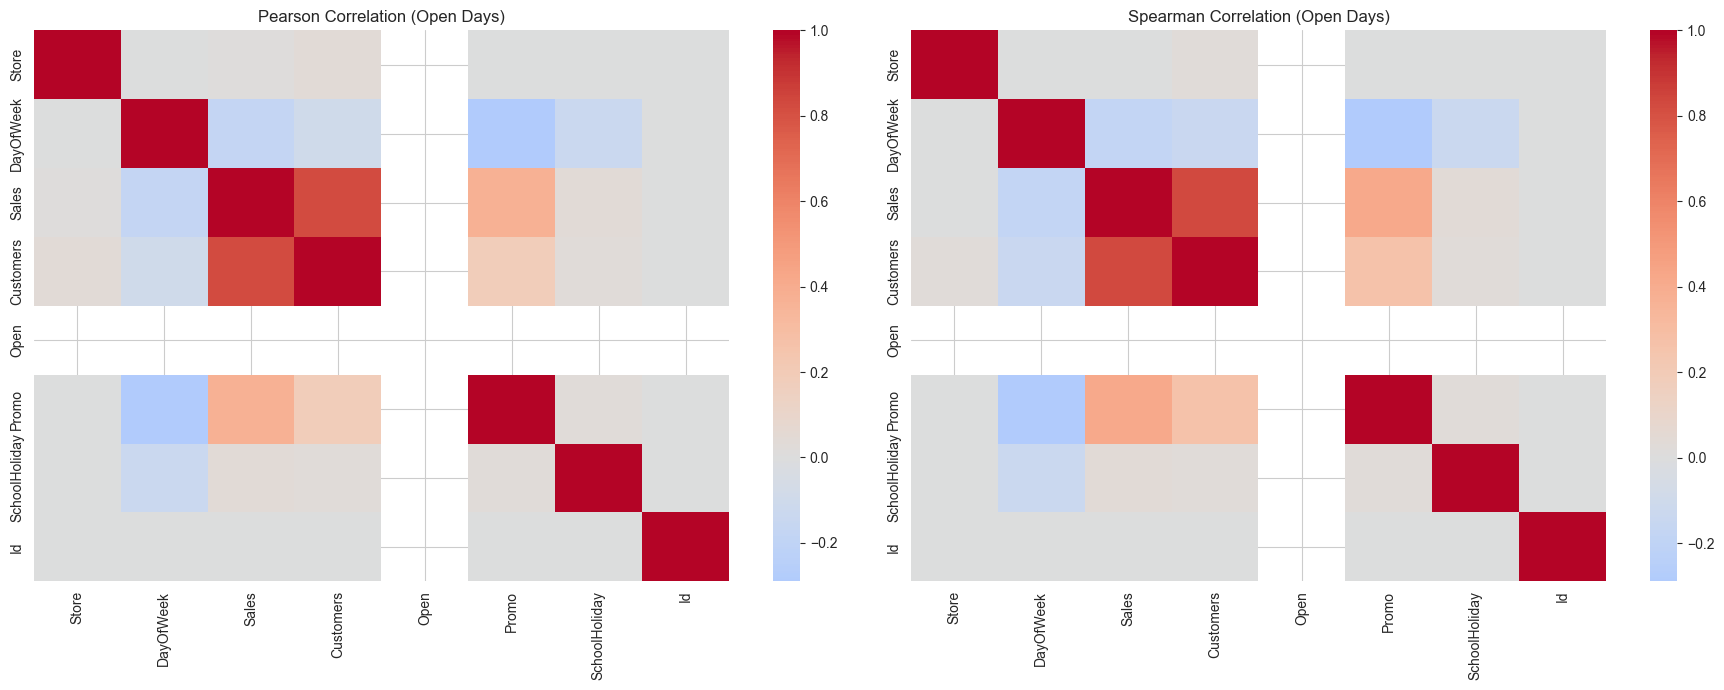

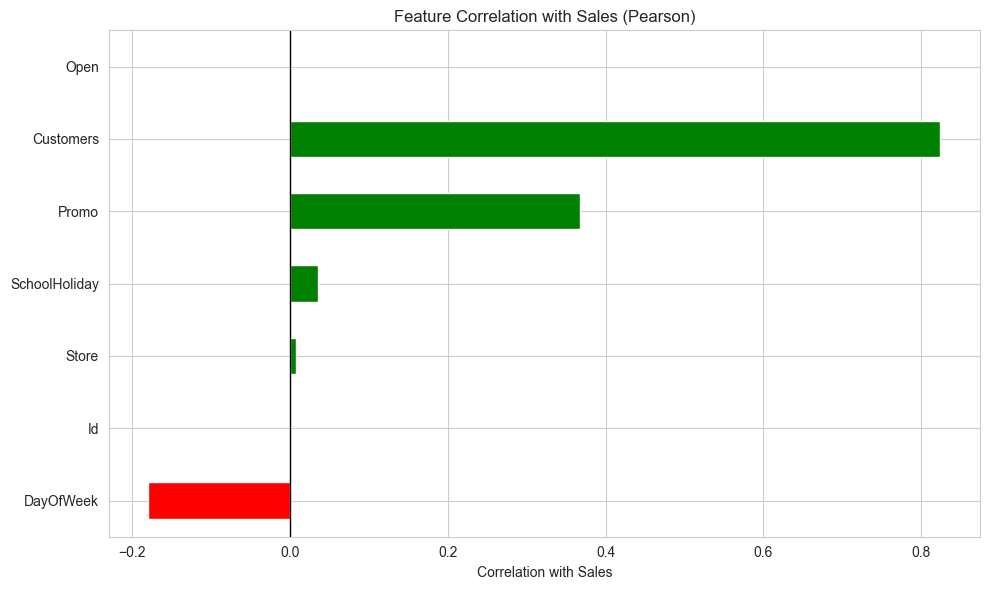

In [7]:
corr_df = train_df[train_df['Open'] == 1].select_dtypes(include=[np.number]).copy()

pearson_corr = corr_df.corr(method='pearson')
spearman_corr = corr_df.corr(method='spearman')

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.heatmap(pearson_corr, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Pearson Correlation (Open Days)')

sns.heatmap(spearman_corr, cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title('Spearman Correlation (Open Days)')

plt.tight_layout()
plt.show()

sales_corr = pearson_corr['Sales'].drop('Sales').sort_values()
colors = ['green' if v > 0 else 'red' for v in sales_corr.values]

plt.figure(figsize=(10, 6))
sales_corr.plot(kind='barh', color=colors)
plt.title('Feature Correlation with Sales (Pearson)')
plt.xlabel('Correlation with Sales')
plt.axvline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()

### 4) Cross-Store Trend Comparison

What we are doing is placing store moving averages on one figure to compare scale and timing.

This helps us see whether stores share common seasonality or exhibit store-specific behavior.

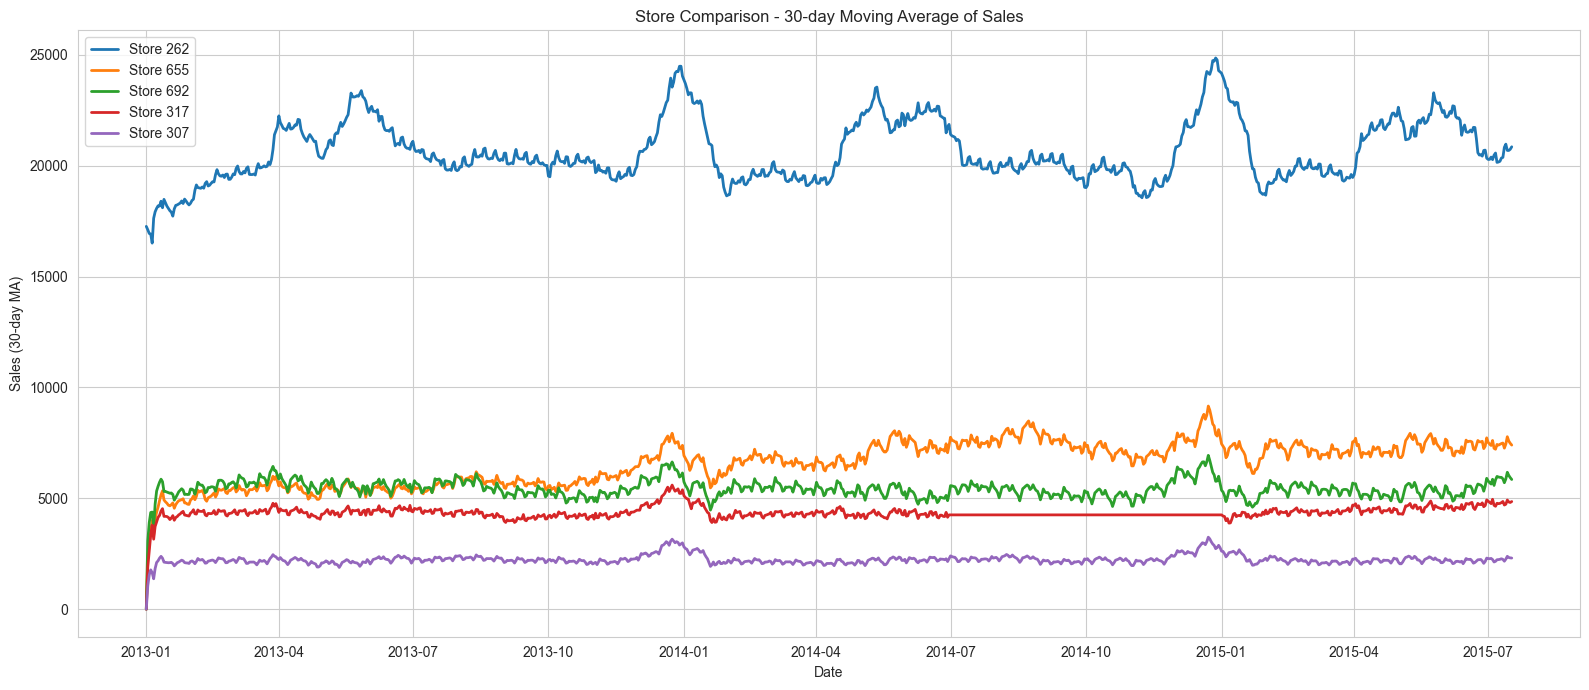

In [8]:
plt.figure(figsize=(16, 7))

for store_id in selected_stores:
    tmp = selected_data[selected_data['Store'] == store_id].sort_values('Date').copy()
    tmp['Sales_MA30'] = tmp['Sales'].rolling(30, min_periods=1).mean()
    plt.plot(tmp['Date'], tmp['Sales_MA30'], linewidth=2, label=f'Store {store_id}')

plt.title('Store Comparison - 30-day Moving Average of Sales')
plt.xlabel('Date')
plt.ylabel('Sales (30-day MA)')
plt.legend()
plt.tight_layout()
plt.show()

## Phase 2 — Feature Engineering

What we are doing now is converting raw merged data into a feature space suitable for modeling.

Each step is designed to be leakage-safe and interpretable, so later model performance can be explained rather than guessed.

### 1) Merge Sales and Store Metadata

What we are doing is a left join on `Store` so every sales row remains present while store attributes are attached.

After merge, we sort by `Store, Date` to make sequential feature generation consistent.

In [3]:
# Merge sales with store metadata (left join keeps all train rows)
df = train_df.merge(store_df, on='Store', how='left').sort_values(['Store', 'Date']).reset_index(drop=True)
print('Merged shape:', df.shape)
df.head()

Merged shape: (1001599, 19)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2,2013-01-01,0,0,0,0,a,1,690197,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,3,2013-01-02,5530,668,1,0,0,1,988300,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,4,2013-01-03,4327,578,1,0,0,1,919910,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,5,2013-01-04,4486,619,1,0,0,1,662609,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,6,2013-01-05,4997,635,1,0,0,1,1008092,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


### 2) Missing Value Handling and Promo Semantics

What we are doing is separating structural missingness from random missingness.

For example, Promo2-related fields are expected to be empty when Promo2 is not active.

We also create semantic promo features (`is_promo2`, `promo2_running`, `is_promo2_month`) so the model learns meaningful campaign states, not only raw columns.

In [4]:
# Rebuild raw categorical columns if notebook is re-run after one-hot encoding
for raw_col in ['StateHoliday', 'PromoInterval', 'StoreType', 'Assortment']:
    if raw_col not in df.columns:
        dummy_cols = [c for c in df.columns if c.startswith(f'{raw_col}_')]
        if dummy_cols:
            df[raw_col] = (
                df[dummy_cols]
                .idxmax(axis=1)
                .str.replace(f'{raw_col}_', '', regex=False)
            )

df['StateHoliday'] = df['StateHoliday'].astype(str)

# Promo2-related missing values are structural when Promo2 == 0
# Keep raw PromoInterval for one-hot, but also derive time-aware promo features.
df['Promo2SinceWeek'] = df['Promo2SinceWeek'].fillna(0).astype(int)
df['Promo2SinceYear'] = df['Promo2SinceYear'].fillna(0).astype(int)
df['PromoInterval'] = df['PromoInterval'].fillna('None').astype(str)

# Promo2 active flag
df['is_promo2'] = (df['Promo2'] == 1).astype('int8')

# Promo2 has started by current date? (year/week logic)
iso_week = df['Date'].dt.isocalendar().week.astype(int)
has_started = (
    (df['Date'].dt.year > df['Promo2SinceYear']) |
    ((df['Date'].dt.year == df['Promo2SinceYear']) & (iso_week >= df['Promo2SinceWeek']))
)
df['promo2_running'] = (df['is_promo2'].eq(1) & has_started).astype('int8')

# Is current month inside store's PromoInterval cycle?
month_abbr = df['Date'].dt.strftime('%b').to_numpy()
promo_interval = df['PromoInterval'].to_numpy()
promo_running = df['promo2_running'].to_numpy()

df['is_promo2_month'] = np.fromiter(
    (
        int(run and (interval != 'None') and (m in interval.replace(' ', '').split(',')))
        for run, m, interval in zip(promo_running, month_abbr, promo_interval)
    ),
    dtype=np.int8,
    count=len(df),
)

# Competition open date missing flags + fill
df['CompetitionOpenSinceMonth_missing'] = df['CompetitionOpenSinceMonth'].isna().astype(int)
df['CompetitionOpenSinceYear_missing'] = df['CompetitionOpenSinceYear'].isna().astype(int)
df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(0).astype(int)
df['CompetitionOpenSinceYear'] = df['CompetitionOpenSinceYear'].fillna(0).astype(int)

# CompetitionDistance imputation: store-type median, fallback global median + missing flag
df['CompetitionDistance_missing'] = df['CompetitionDistance'].isna().astype(int)
dist_median_by_type = df.groupby('StoreType')['CompetitionDistance'].transform('median')
global_dist_median = df['CompetitionDistance'].median()
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(dist_median_by_type).fillna(global_dist_median)

print('Promo features preview:')
display(df[['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'is_promo2', 'promo2_running', 'is_promo2_month']].head(10))

print('Remaining missing values (>0):')
display(df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False).to_frame('missing_count'))

Promo features preview:


,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,is_promo2,promo2_running,is_promo2_month
0,0,0,0,None,0,0,0
1,0,0,0,None,0,0,0
2,0,0,0,None,0,0,0
3,0,0,0,None,0,0,0
4,0,0,0,None,0,0,0
5,0,0,0,None,0,0,0
6,0,0,0,None,0,0,0
7,0,0,0,None,0,0,0
8,0,0,0,None,0,0,0
9,0,0,0,None,0,0,0


Remaining missing values (>0):


,missing_count


### 3) Core Time Features

What we are doing is adding calendar-derived predictors (year, month, week, weekday, weekend).

These are foundational because retail demand often has strong calendar structure.

In [5]:
# Core calendar features (simple and strong baseline for tree models)
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['weekofyear'] = df['Date'].dt.isocalendar().week.astype(int)
df['day'] = df['Date'].dt.day
df['dayofweek'] = df['Date'].dt.dayofweek
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

df[['Date', 'year', 'month', 'weekofyear', 'day', 'dayofweek', 'is_weekend']].head()

,Date,year,month,weekofyear,day,dayofweek,is_weekend
0,2013-01-01,2013,1,1,1,1,0
1,2013-01-02,2013,1,1,2,2,0
2,2013-01-03,2013,1,1,3,3,0
3,2013-01-04,2013,1,1,4,4,0
4,2013-01-05,2013,1,1,5,5,1


### 4) Lag and Rolling Features

What we are doing is encoding store memory:
- lag features capture values at specific past offsets,
- rolling statistics capture local trend and variability.

Rolling features are computed on shifted values to avoid leakage from the current day.

In [6]:
lag_list = [1, 7, 14, 28]
roll_windows = [7, 14, 28, 56]

lag_feature_cols = []
roll_mean_cols = []
roll_std_cols = []

for lag in lag_list:
    sales_lag_col = f'Sales_lag_{lag}'
    customers_lag_col = f'Customers_lag_{lag}'

    df[sales_lag_col] = df.groupby('Store')['Sales'].shift(lag)
    df[customers_lag_col] = df.groupby('Store')['Customers'].shift(lag)

    lag_feature_cols.extend([sales_lag_col, customers_lag_col])

shifted_sales = df.groupby('Store')['Sales'].shift(1)
shifted_customers = df.groupby('Store')['Customers'].shift(1)

for w in roll_windows:
    sales_roll_mean_col = f'Sales_roll_mean_{w}'
    sales_roll_std_col = f'Sales_roll_std_{w}'
    customers_roll_mean_col = f'Customers_roll_mean_{w}'
    customers_roll_std_col = f'Customers_roll_std_{w}'

    df[sales_roll_mean_col] = shifted_sales.groupby(df['Store']).rolling(window=w, min_periods=1).mean().reset_index(level=0, drop=True)
    df[sales_roll_std_col] = shifted_sales.groupby(df['Store']).rolling(window=w, min_periods=1).std().reset_index(level=0, drop=True)

    df[customers_roll_mean_col] = shifted_customers.groupby(df['Store']).rolling(window=w, min_periods=1).mean().reset_index(level=0, drop=True)
    df[customers_roll_std_col] = shifted_customers.groupby(df['Store']).rolling(window=w, min_periods=1).std().reset_index(level=0, drop=True)

    roll_mean_cols.extend([sales_roll_mean_col, customers_roll_mean_col])
    roll_std_cols.extend([sales_roll_std_col, customers_roll_std_col])

generated_ts_cols = lag_feature_cols + roll_mean_cols + roll_std_cols
missing_before = df[generated_ts_cols].isna().sum().sum()

# Keep missing-pattern information explicitly
for col in generated_ts_cols:
    df[f'{col}_missing'] = df[col].isna().astype('int8')

# Safe imputation for time-series engineered features (no future-value borrowing)
df[lag_feature_cols + roll_mean_cols] = df[lag_feature_cols + roll_mean_cols].fillna(0.0)
df[roll_std_cols] = df[roll_std_cols].fillna(0.0)

missing_after = df[generated_ts_cols].isna().sum().sum()
print(f'Missing in lag/rolling features - before: {missing_before:,} | after: {missing_after:,}')

df.filter(regex='Sales_lag|Customers_lag|Sales_roll|Customers_roll').head(20)

Missing in lag/rolling features - before: 138,260 | after: 0


,Sales_lag_1,Customers_lag_1,Sales_lag_7,Customers_lag_7,Sales_lag_14,Customers_lag_14,Sales_lag_28,Customers_lag_28,Sales_roll_mean_7,Sales_roll_std_7,...,Sales_roll_mean_56_missing,Customers_roll_mean_56_missing,Sales_roll_std_7_missing,Customers_roll_std_7_missing,Sales_roll_std_14_missing,Customers_roll_std_14_missing,Sales_roll_std_28_missing,Customers_roll_std_28_missing,Sales_roll_std_56_missing,Customers_roll_std_56_missing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1,1,1,1,1,1,1,1,1,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,1,1,1,1,1,1,1,1
2,5530.0,668.0,0.0,0.0,0.0,0.0,0.0,0.0,2765.000000,3910.300500,...,0,0,0,0,0,0,0,0,0,0
3,4327.0,578.0,0.0,0.0,0.0,0.0,0.0,0.0,3285.666667,2908.351137,...,0,0,0,0,0,0,0,0,0,0
4,4486.0,619.0,0.0,0.0,0.0,0.0,0.0,0.0,3585.750000,2449.327306,...,0,0,0,0,0,0,0,0,0,0
5,4997.0,635.0,0.0,0.0,0.0,0.0,0.0,0.0,3868.000000,2213.081223,...,0,0,0,0,0,0,0,0,0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3223.333333,2532.144045,...,0,0,0,0,0,0,0,0,0,0
7,7176.0,785.0,0.0,0.0,0.0,0.0,0.0,0.0,3788.000000,2752.283961,...,0,0,0,0,0,0,0,0,0,0
8,5580.0,654.0,5530.0,668.0,0.0,0.0,0.0,0.0,4585.142857,2231.018633,...,0,0,0,0,0,0,0,0,0,0
9,5471.0,626.0,4327.0,578.0,0.0,0.0,0.0,0.0,4576.714286,2226.961885,...,0,0,0,0,0,0,0,0,0,0


### 5) Advanced Time, Competition, and Store-History Features (No External Data)

What we are doing now is building a richer feature layer **only from trusted competition data** (`train.csv` + `store.csv`).

Because you explicitly said legacy external files are random and unreliable, we intentionally do **not** use weather, external trends, or generated state mapping in this notebook.

This block adds leakage-safe, interpretable signals in six groups:

1. **Fourier seasonality terms** (weekly + yearly) to model smooth periodic behavior.
2. **Cyclic calendar encoding** (`sin/cos`) for day-of-week and month.
3. **Holiday-distance and holiday-window features** from the observed calendar in the data.
4. **Competition and Promo2 maturity clocks** (how long a regime has been active).
5. **Leakage-safe expanding store history** (computed on shifted values only).
6. **Interaction and recency-difference features** that capture nonlinear effects and local momentum.

Design rules in this section:
- We never use current/future target values when building predictors.
- Every historical aggregate uses `.shift(1)` before expanding/rolling.
- Any feature touching `Sales` uses past `Sales` (lagged) rather than current `Sales`.
- We retain missingness flags where they carry information about data availability.

In [7]:
# ------------------------------
# 5A) Normalize holiday semantics before advanced features
# ------------------------------
# We standardize string values so holiday logic behaves consistently.
df['StateHoliday'] = df['StateHoliday'].astype(str).replace({'0.0': '0', 'nan': '0'})

# ------------------------------
# 5B) Fourier seasonality terms (weekly + yearly)
# ------------------------------
# Fourier terms model periodic patterns with smooth basis functions.
# They often capture seasonality better than raw month/week integers alone.
t_days = (df['Date'] - df['Date'].min()).dt.days.astype(float)
for k in [1, 2, 3]:
    df[f'fourier_year_sin_{k}'] = np.sin(2 * np.pi * k * t_days / 365.25)
    df[f'fourier_year_cos_{k}'] = np.cos(2 * np.pi * k * t_days / 365.25)

for k in [1, 2]:
    df[f'fourier_week_sin_{k}'] = np.sin(2 * np.pi * k * t_days / 7.0)
    df[f'fourier_week_cos_{k}'] = np.cos(2 * np.pi * k * t_days / 7.0)

# ------------------------------
# 5C) Cyclic encodings for calendar features
# ------------------------------
# Calendar integers (e.g., dayofweek=0..6) have circular structure.
# Sine/cosine encoding preserves "distance" between endpoints (Sun~Mon, Dec~Jan).
dow = df['dayofweek'].astype(float)
month = df['month'].astype(float)
df['dayofweek_sin'] = np.sin(2 * np.pi * dow / 7.0)
df['dayofweek_cos'] = np.cos(2 * np.pi * dow / 7.0)
df['month_sin'] = np.sin(2 * np.pi * month / 12.0)
df['month_cos'] = np.cos(2 * np.pi * month / 12.0)

# ------------------------------
# 5D) Distance to nearest state holiday (global calendar in train)
# ------------------------------
# We derive holiday distance from dates where StateHoliday != '0'.
# Distances become directional clocks around holidays.
# NOTE: enforce datetime64 arrays to avoid object-dtype arithmetic issues across pandas/numpy versions.
unique_dates = np.sort(np.unique(df['Date'].dt.normalize().to_numpy(dtype='datetime64[ns]')))
holiday_dates = np.sort(np.unique(df.loc[df['StateHoliday'] != '0', 'Date'].dt.normalize().to_numpy(dtype='datetime64[ns]')))

if len(holiday_dates) > 0:
    pos = np.searchsorted(holiday_dates, unique_dates)

    prev_dist = np.full(len(unique_dates), np.nan, dtype=float)
    next_dist = np.full(len(unique_dates), np.nan, dtype=float)

    prev_ok = pos > 0
    next_ok = pos < len(holiday_dates)

    prev_idx = np.where(prev_ok, pos - 1, 0)
    next_idx = np.where(next_ok, pos, len(holiday_dates) - 1)

    prev_dist[prev_ok] = (unique_dates[prev_ok] - holiday_dates[prev_idx[prev_ok]]) / np.timedelta64(1, 'D')
    next_dist[next_ok] = (holiday_dates[next_idx[next_ok]] - unique_dates[next_ok]) / np.timedelta64(1, 'D')

    holiday_distance_map = pd.DataFrame({
        'Date': pd.to_datetime(unique_dates),
        'days_since_prev_stateholiday': prev_dist,
        'days_to_next_stateholiday': next_dist,
    })
else:
    holiday_distance_map = pd.DataFrame({
        'Date': pd.to_datetime(unique_dates),
        'days_since_prev_stateholiday': np.nan,
        'days_to_next_stateholiday': np.nan,
    })

df = df.merge(holiday_distance_map, on='Date', how='left')

# Large fill value (999) means "no nearby observed holiday".
df['days_since_prev_stateholiday'] = df['days_since_prev_stateholiday'].fillna(999).clip(upper=999)
df['days_to_next_stateholiday'] = df['days_to_next_stateholiday'].fillna(999).clip(upper=999)
df['is_within_3d_after_holiday'] = (df['days_since_prev_stateholiday'] <= 3).astype('int8')
df['is_within_3d_before_holiday'] = (df['days_to_next_stateholiday'] <= 3).astype('int8')
df['is_holiday_window_7d'] = (
    (df['days_since_prev_stateholiday'] <= 7) | (df['days_to_next_stateholiday'] <= 7)
).astype('int8')

# ------------------------------
# 5E) Competition maturity + Promo2 maturity clocks
# ------------------------------
# Competition maturity: how long competitor has been open for a store.
comp_month = df['CompetitionOpenSinceMonth'].replace(0, np.nan)
comp_year = df['CompetitionOpenSinceYear'].replace(0, np.nan)

comp_year_str = comp_year.fillna(-1).astype(int).astype(str)
comp_month_str = comp_month.fillna(-1).astype(int).astype(str).str.zfill(2)
comp_open_date = pd.to_datetime(
    comp_year_str + '-' + comp_month_str + '-01',
    errors='coerce'
)

months_since_comp = (
    (df['Date'].dt.year - comp_open_date.dt.year) * 12 +
    (df['Date'].dt.month - comp_open_date.dt.month)
)

df['months_since_competition_open'] = months_since_comp.fillna(-1).clip(lower=-1).astype(float)
df['competition_open_known'] = comp_open_date.notna().astype('int8')
df['competition_active'] = (df['months_since_competition_open'] >= 0).astype('int8')
df['competition_distance_log1p'] = np.log1p(np.clip(df['CompetitionDistance'], 0, None))

# Distance band remains useful as a nonlinear categorical proxy.
df['competition_distance_band'] = pd.cut(
    df['CompetitionDistance'],
    bins=[-np.inf, 250, 1000, 3000, np.inf],
    labels=['very_near', 'near', 'mid', 'far']
).astype(str)

# Promo2 maturity: weeks since Promo2 start (only when promo2 is active and started).
promo2_week = df['Promo2SinceWeek'].replace(0, np.nan)
promo2_year = df['Promo2SinceYear'].replace(0, np.nan)

promo2_start_str = (
    promo2_year.fillna(-1).astype(int).astype(str) + ' ' +
    promo2_week.fillna(-1).astype(int).astype(str).str.zfill(2) + ' 1'
 )
promo2_start_date = pd.to_datetime(promo2_start_str, format='%G %V %u', errors='coerce')

promo2_weeks_since_start = ((df['Date'] - promo2_start_date).dt.days / 7.0)
df['promo2_weeks_since_start'] = promo2_weeks_since_start.where(df['promo2_running'].eq(1), 0.0).fillna(0.0)
df['promo2_recent_start_8w'] = ((df['promo2_running'].eq(1)) & (df['promo2_weeks_since_start'] <= 8)).astype('int8')

# ------------------------------
# 5F) Leakage-safe expanding historical statistics
# ------------------------------
# IMPORTANT: every historical summary starts from shifted series.
# That guarantees we only use information available before current day t.
shifted_sales = df.groupby('Store')['Sales'].shift(1)
shifted_customers = df.groupby('Store')['Customers'].shift(1)

df['store_sales_exp_mean'] = shifted_sales.groupby(df['Store']).expanding().mean().reset_index(level=0, drop=True)
df['store_sales_exp_median'] = shifted_sales.groupby(df['Store']).expanding().median().reset_index(level=0, drop=True)
df['store_sales_exp_std'] = shifted_sales.groupby(df['Store']).expanding().std().reset_index(level=0, drop=True)
df['store_sales_exp_min'] = shifted_sales.groupby(df['Store']).expanding().min().reset_index(level=0, drop=True)
df['store_sales_exp_max'] = shifted_sales.groupby(df['Store']).expanding().max().reset_index(level=0, drop=True)

df['store_customers_exp_mean'] = shifted_customers.groupby(df['Store']).expanding().mean().reset_index(level=0, drop=True)
df['store_customers_exp_std'] = shifted_customers.groupby(df['Store']).expanding().std().reset_index(level=0, drop=True)

shifted_sales_store_dow = df.groupby(['Store', 'DayOfWeek'])['Sales'].shift(1)
df['store_dow_sales_exp_mean'] = (
    shifted_sales_store_dow
    .groupby([df['Store'], df['DayOfWeek']])
    .expanding()
    .mean()
    .reset_index(level=[0, 1], drop=True)
)

# Replace leakage-prone target-dependent feature with lag-based analog.
# OLD (removed): sales_vs_store_exp_mean = current Sales - store_sales_exp_mean
df['sales_lag1_vs_store_exp_mean'] = df['Sales_lag_1'] - df['store_sales_exp_mean']
df['sales_lag1_store_zscore'] = (df['Sales_lag_1'] - df['store_sales_exp_mean']) / (df['store_sales_exp_std'] + 1.0)

# ------------------------------
# 5G) Interaction and recency-difference features
# ------------------------------
# Interactions help models express context-dependent effects.
df['promo_x_schoolholiday'] = (df['Promo'] * df['SchoolHoliday']).astype(float)
df['promo_x_weekend'] = (df['Promo'] * df['is_weekend']).astype(float)
df['promo2_x_holiday_window'] = (df['promo2_running'] * df['is_holiday_window_7d']).astype(float)
df['competition_active_x_promo'] = (df['competition_active'] * df['Promo']).astype(float)
df['competition_distance_x_promo'] = (df['competition_distance_log1p'] * df['Promo']).astype(float)

# Recency differences summarize short-vs-medium momentum from lag features.
df['sales_diff_lag1_lag7'] = df['Sales_lag_1'] - df['Sales_lag_7']
df['sales_diff_lag7_lag28'] = df['Sales_lag_7'] - df['Sales_lag_28']
df['customers_diff_lag1_lag7'] = df['Customers_lag_1'] - df['Customers_lag_7']

# Ratio-style stability features with safe denominator guards.
df['sales_lag1_to_roll7'] = df['Sales_lag_1'] / (df['Sales_roll_mean_7'] + 1.0)
df['customers_lag1_to_roll7'] = df['Customers_lag_1'] / (df['Customers_roll_mean_7'] + 1.0)

# ------------------------------
# 5H) Missingness flags + safe fills for newly created advanced features
# ------------------------------
advanced_numeric_cols = [
    'store_sales_exp_mean', 'store_sales_exp_median', 'store_sales_exp_std',
    'store_sales_exp_min', 'store_sales_exp_max', 'store_customers_exp_mean',
    'store_customers_exp_std', 'store_dow_sales_exp_mean',
    'sales_lag1_vs_store_exp_mean', 'sales_lag1_store_zscore',
    'sales_diff_lag1_lag7', 'sales_diff_lag7_lag28', 'customers_diff_lag1_lag7',
    'sales_lag1_to_roll7', 'customers_lag1_to_roll7',
    'promo2_weeks_since_start'
 ]

for col in advanced_numeric_cols:
    df[f'{col}_missing'] = df[col].isna().astype('int8')

df[advanced_numeric_cols] = df[advanced_numeric_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)

print('Advanced in-dataset feature engineering complete (no external legacy data).')
print('Current dataframe shape:', df.shape)
print('Preview of selected advanced columns:')
new_feature_preview = [
    'fourier_year_sin_1', 'dayofweek_sin', 'month_cos',
    'days_since_prev_stateholiday', 'days_to_next_stateholiday',
    'months_since_competition_open', 'promo2_weeks_since_start',
    'store_sales_exp_mean', 'sales_lag1_vs_store_exp_mean', 'sales_lag1_store_zscore',
    'promo_x_schoolholiday', 'sales_diff_lag1_lag7', 'sales_lag1_to_roll7'
 ]
display(df[[c for c in new_feature_preview if c in df.columns]].head())

Advanced in-dataset feature engineering complete (no external legacy data).
Current dataframe shape: (1001599, 141)
Preview of selected advanced columns:


,fourier_year_sin_1,dayofweek_sin,month_cos,days_since_prev_stateholiday,days_to_next_stateholiday,months_since_competition_open,promo2_weeks_since_start,store_sales_exp_mean,sales_lag1_vs_store_exp_mean,sales_lag1_store_zscore,promo_x_schoolholiday,sales_diff_lag1_lag7,sales_lag1_to_roll7
0,0.000000,0.781831,0.866025,999.0,0.0,52.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1,0.017202,0.974928,0.866025,1.0,4.0,52.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,0.034398,0.433884,0.866025,2.0,3.0,52.0,0.0,2765.000000,2765.000000,0.706926,0.0,5530.0,1.999277
3,0.051584,-0.433884,0.866025,3.0,2.0,52.0,0.0,3285.666667,1041.333333,0.357926,0.0,4327.0,1.316531
4,0.068755,-0.974928,0.866025,4.0,1.0,52.0,0.0,3585.750000,900.250000,0.367400,0.0,4486.0,1.250714


### 6) Categorical Encoding and **Type-Aware** Numeric Scaling

What we are doing here is preparing the enriched dataframe for modeling while respecting the semantic type of each column:

1. One-hot encode categorical text columns,
2. Keep identifier columns as identifiers (never scaled, never used as predictive features),
3. Keep binary flags as 0/1 indicators (not robust-scaled),
4. Scale only true continuous/count-like numeric features with `RobustScaler`.

Why this matters for sound modeling:
- `Id` and `Store` are identifiers, not magnitudes. Treating them as ranged numeric values is conceptually wrong.
- Boolean fields like `Open`, `Promo`, `SchoolHoliday` should stay interpretable as 0/1 states.
- Robust scaling remains useful for heavy-tailed continuous variables (sales-history stats, distances, clocks).
- This design avoids injecting spurious ordinal meaning into IDs and preserves clean feature semantics.

In [14]:
# Encode all categorical columns generated so far (dynamic, not hard-coded)
categorical_cols = [
    c for c in df.select_dtypes(include=['object', 'category']).columns
    if c != 'Date'
 ]

print('Categorical columns to encode:', len(categorical_cols))
if categorical_cols:
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)
    print('One-hot encoding applied.')
else:
    print('No categorical columns found. Skipping get_dummies.')

# ------------------------------
# Type-aware feature treatment
# ------------------------------
# Preserve identifier semantics explicitly.
if 'Store' in df.columns:
    df['StoreRaw'] = df['Store'].astype('int32')
if 'Id' in df.columns:
    df['IdRaw'] = df['Id'].astype('int64')

identifier_cols = [c for c in ['Id', 'IdRaw', 'Store', 'StoreRaw'] if c in df.columns]

# Detect binary indicators (including one-hot outputs): values subset of {0, 1}.
binary_like_cols = []
for c in df.select_dtypes(include=[np.number]).columns:
    non_na_vals = pd.Series(df[c]).dropna().unique()
    if len(non_na_vals) <= 2 and set(np.asarray(non_na_vals).tolist()).issubset({0, 1}):
        binary_like_cols.append(c)

# Keep binary columns as compact integer indicators.
for c in binary_like_cols:
    df[c] = df[c].fillna(0).astype('int8')

# Prepare numeric columns for robust scaling (exclude target/date/IDs/binaries).
exclude_for_scaling = set(['Date', 'Sales']) | set(identifier_cols) | set(binary_like_cols)
scale_cols = [
    c for c in df.select_dtypes(include=[np.number]).columns
    if c not in exclude_for_scaling
]

# Defensive cleanup for numeric stability before scaling continuous/count-like columns.
df[scale_cols] = df[scale_cols].replace([np.inf, -np.inf], np.nan)
df[scale_cols] = df[scale_cols].fillna(0.0)

scaler = RobustScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

print('Final engineered dataframe shape:', df.shape)
print('Identifier columns (unscaled):', identifier_cols)
print('Binary indicator columns (unscaled 0/1):', len(binary_like_cols))
print('Scaled continuous/count-like numeric columns:', len(scale_cols))

Categorical columns to encode: 5
One-hot encoding applied.
Final engineered dataframe shape: (1001599, 157)
Identifier columns (unscaled): ['Id', 'IdRaw', 'Store', 'StoreRaw']
Binary indicator columns (unscaled 0/1): 61
Scaled continuous/count-like numeric columns: 71


### 7) Chronological Train/Validation/Test Split

What we are doing is splitting by date order (80/10/10), not random sampling.

This mirrors real forecasting where future timestamps must be predicted from past information only.

In [15]:
# Chronological split (no shuffling) to mimic forecasting setup
unique_dates = np.array(sorted(df['Date'].unique()))
n_dates = len(unique_dates)

train_end_idx = int(n_dates * 0.80)
val_end_idx = int(n_dates * 0.90)

train_end_date = unique_dates[train_end_idx - 1]
val_end_date = unique_dates[val_end_idx - 1]

train_split = df[df['Date'] <= train_end_date].copy()
val_split = df[(df['Date'] > train_end_date) & (df['Date'] <= val_end_date)].copy()
test_split = df[df['Date'] > val_end_date].copy()

print('Date boundaries:')
print('  Train end:', train_end_date)
print('  Val end  :', val_end_date)

print('Split shapes:')
print('  Train:', train_split.shape)
print('  Val  :', val_split.shape)
print('  Test :', test_split.shape)

Date boundaries:
  Train end: 2015-01-12 00:00:00
  Val end  : 2015-04-15 00:00:00
Split shapes:
  Train: (794209, 157)
  Val  : (103695, 157)
  Test : (103695, 157)


### Exporting Artifacts for Downstream Phases

What we are doing in the next code cell is writing model-ready artifacts to disk in both pickle and CSV formats, plus metadata files.

This guarantees that downstream notebooks can load the exact same prepared data.

In [16]:
from pathlib import Path
import json
import pickle

# Output layout
output_dir = Path('../data/phase2_output')
pkl_dir = output_dir / 'pkl'
csv_dir = output_dir / 'csv'
output_dir.mkdir(parents=True, exist_ok=True)
pkl_dir.mkdir(parents=True, exist_ok=True)
csv_dir.mkdir(parents=True, exist_ok=True)

# --------------------
# 1) Save data artifacts in PKL (fast load, keeps dtypes)
# --------------------
df.to_pickle(pkl_dir / 'engineered_full.pkl')
train_split.to_pickle(pkl_dir / 'train_split.pkl')
val_split.to_pickle(pkl_dir / 'val_split.pkl')
test_split.to_pickle(pkl_dir / 'test_split.pkl')

# Scaler object (pickle only)
with open(pkl_dir / 'robust_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# --------------------
# 2) Save tabular artifacts in CSV (portable format)
# --------------------
df.to_csv(csv_dir / 'engineered_full.csv', index=False)
train_split.to_csv(csv_dir / 'train_split.csv', index=False)
val_split.to_csv(csv_dir / 'val_split.csv', index=False)
test_split.to_csv(csv_dir / 'test_split.csv', index=False)

# --------------------
# 3) Save metadata and feature list at root
# --------------------
# Exclude date/target and identifier columns from model feature list.
id_feature_exclusions = ['Date', 'Sales', 'Id', 'IdRaw', 'Store', 'StoreRaw']
feature_cols = [c for c in df.columns if c not in id_feature_exclusions]
metadata = {
    'engineered_shape': [int(df.shape[0]), int(df.shape[1])],
    'train_shape': [int(train_split.shape[0]), int(train_split.shape[1])],
    'val_shape': [int(val_split.shape[0]), int(val_split.shape[1])],
    'test_shape': [int(test_split.shape[0]), int(test_split.shape[1])],
    'target_column': 'Sales',
    'date_column': 'Date',
    'identifier_columns': [c for c in ['Id', 'IdRaw', 'Store', 'StoreRaw'] if c in df.columns],
    'n_features': int(len(feature_cols)),
    'pkl_subdir': 'pkl',
    'csv_subdir': 'csv'
}

with open(output_dir / 'metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

with open(output_dir / 'feature_columns.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(feature_cols))

# --------------------
# 4) README for downstream phases
# --------------------
readme_text = """# Phase 2 Output Files

This folder stores the final engineered outputs from `solution/phase1_phase2.ipynb`.

## Folder structure

- `pkl/`: binary artifacts for fast loading in Python.
- `csv/`: tabular artifacts in CSV format for portability.
- `metadata.json`: shapes, key columns, and export structure.
- `feature_columns.txt`: model feature list (excluding target/date/identifier columns).

## Files and usage

### pkl/

- `engineered_full.pkl`: full engineered dataframe (all rows).
- `train_split.pkl`: chronological train split (80%).
- `val_split.pkl`: chronological validation split (10%).
- `test_split.pkl`: chronological test split (10%).
- `robust_scaler.pkl`: fitted `RobustScaler` used on continuous/count-like numeric columns.

Recommended for Phase 3/4/5 if you work in Python and want dtype fidelity and faster IO.

### csv/

- `engineered_full.csv`: full engineered dataframe in CSV format.
- `train_split.csv`: train split in CSV.
- `val_split.csv`: validation split in CSV.
- `test_split.csv`: test split in CSV.

Recommended when sharing data across tools/languages or for quick manual inspection.

## Quick load examples

```python
import pandas as pd
import pickle

base = 'data/phase2_output'

# PKL
train_df = pd.read_pickle(f'{base}/pkl/train_split.pkl')
with open(f'{base}/pkl/robust_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# CSV
train_csv = pd.read_csv(f'{base}/csv/train_split.csv')
```

## Notes

- Target column: `Sales`
- Date column: `Date`
- Identifier columns are kept in the tables for traceability but excluded from `feature_columns.txt`.
- Features for modeling are listed in `feature_columns.txt`.
"""

with open(output_dir / 'README.md', 'w', encoding='utf-8') as f:
    f.write(readme_text)

print('Saved phase2 outputs to:', output_dir.resolve())
print('\nTop-level files:')
for p in sorted(output_dir.glob('*')):
    print('-', p.name)

print('\nPKL files:')
for p in sorted(pkl_dir.glob('*')):
    print('-', p.name)

print('\nCSV files:')
for p in sorted(csv_dir.glob('*')):
    print('-', p.name)

Saved phase2 outputs to: /Users/moparo/u/mlproject/data/phase2_output

Top-level files:
- .DS_Store
- README.md
- csv
- feature_columns.txt
- metadata.json
- pkl

PKL files:
- engineered_full.pkl
- robust_scaler.pkl
- test_split.pkl
- train_split.pkl
- val_split.pkl

CSV files:
- engineered_full.csv
- test_split.csv
- train_split.csv
- val_split.csv


## Final Phase 2 Outputs

What we are doing in the final step is exporting all artifacts needed for downstream modeling:
- engineered full dataset,
- chronological splits,
- fitted scaler,
- metadata and feature list.

This makes the next phase reproducible and versionable.